In [1]:
import pandas as pd
import numpy as np
from scipy.signal import medfilt

def remove_baseline_wandering_qir(signal, kernel_size=51):
    """Remove baseline wandering using median filtering."""
    baseline = medfilt(signal, kernel_size=kernel_size)  # Estimate baseline using median filter
    corrected_signal = signal - baseline  # Remove baseline
    return corrected_signal

def remove_outliers_qir(data):
    """Remove outliers using the IQR method."""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return np.clip(data, lower_bound, upper_bound)  # Replace outliers with bounds

# Load the dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_NaN_Removed.csv"
df = pd.read_csv(file_path)

# Separate numeric and non-numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns

# Apply baseline removal and outlier removal to numeric columns only
df_filtered = df.copy()
df_filtered[numeric_columns] = df_filtered[numeric_columns].apply(remove_baseline_wandering_qir)
df_filtered[numeric_columns] = df_filtered[numeric_columns].apply(remove_outliers_qir)

# Ensure non-numeric columns remain unchanged
df_filtered[non_numeric_columns] = df[non_numeric_columns]

# Save the cleaned file
output_file = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_Cleaned_QIR.csv" # Update with desired output path
df_filtered.to_csv(output_file, index=False)

print(f"Processed file saved as: {output_file}")


Processed file saved as: C:\Users\ADWIN ADI\Downloads\breathing.csv files\MainData_Cleaned_QIR.csv


Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0          0.06            0.0263              0.01          0.05   
1          0.05            0.0261              0.01          0.04   
2          0.04            0.0221              0.19          0.03   
3          0.04            0.0119              0.32          0.03   
4          0.04            0.0117              0.38          0.03   

   Sensor2_Pressure  Sensor2_Humidity Label  
0            0.0338               0.0     N  
1            0.0440               0.0     N  
2            0.0562               0.0     N  
3            0.0457               0.0     N  
4            0.0344               0.0     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 4s 96ms/step - loss: 1.1313 - accuracy: 0.3942 - val_loss: 0.8899 - val_accuracy: 0.6054
Epoch 2/50
19/19 [==============================] - 1s 64ms/step - loss: 0.8343 - ac

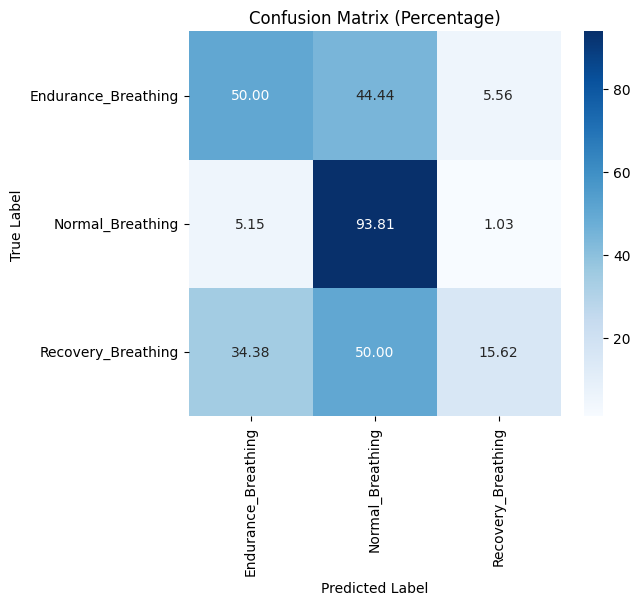

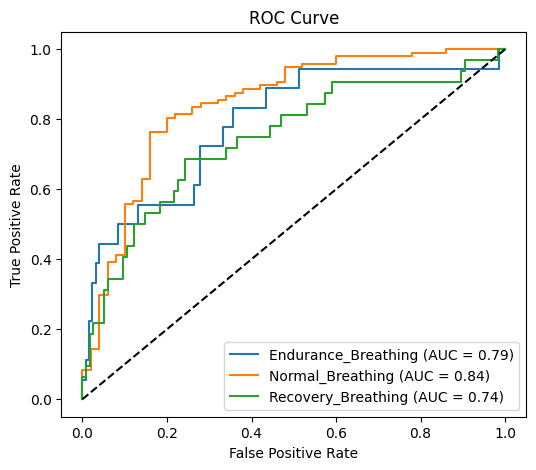


Performance Metrics:
                 Class  Precision  Recall  F1 Score  Support  Accuracy    Loss
0  Endurance Breathing     0.3600  0.5000    0.4186       18    0.7143  0.7392
1     Normal Breathing     0.7913  0.9381    0.8585       97    0.7143  0.7392
2   Recovery Breathing     0.7143  0.1562    0.2564       32    0.7143  0.7392
3              Overall     0.6219  0.5315    0.5112      147    0.7143  0.7392
Model training completed and saved.


In [7]:
#RNN MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_Cleaned_QIR.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build SimpleRNN model
model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Evaluate model
loss = model.evaluate(X_test, y_test, verbose=0)[0]
accuracy = accuracy_score(y_test_labels, y_pred)

# Compute classification metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
class_names = ['Endurance Breathing', 'Normal Breathing', 'Recovery Breathing']

# Build performance table
performance_table = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Support": support
})

# Add overall metrics
overall_row = pd.DataFrame([{
    "Class": "Overall",
    "Precision": precision.mean(),
    "Recall": recall.mean(),
    "F1 Score": f1.mean(),
    "Support": support.sum()
}])
performance_table = pd.concat([performance_table, overall_row], ignore_index=True)

# Add loss and accuracy as new columns (same for all rows)
performance_table["Accuracy"] = accuracy
performance_table["Loss"] = loss

# Display the table
print("\nPerformance Metrics:")
print(performance_table.round(4))

print("Model training completed and saved.")

Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0          0.06            0.0263              0.01          0.05   
1          0.05            0.0261              0.01          0.04   
2          0.04            0.0221              0.19          0.03   
3          0.04            0.0119              0.32          0.03   
4          0.04            0.0117              0.38          0.03   

   Sensor2_Pressure  Sensor2_Humidity Label  
0            0.0338               0.0     N  
1            0.0440               0.0     N  
2            0.0562               0.0     N  
3            0.0457               0.0     N  
4            0.0344               0.0     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 11s 254ms/step - loss: 1.0435 - accuracy: 0.5290 - val_loss: 0.9277 - val_accuracy: 0.6871
Epoch 2/50
19/19 [==============================] - 3s 163ms/step - loss: 0.8167 -

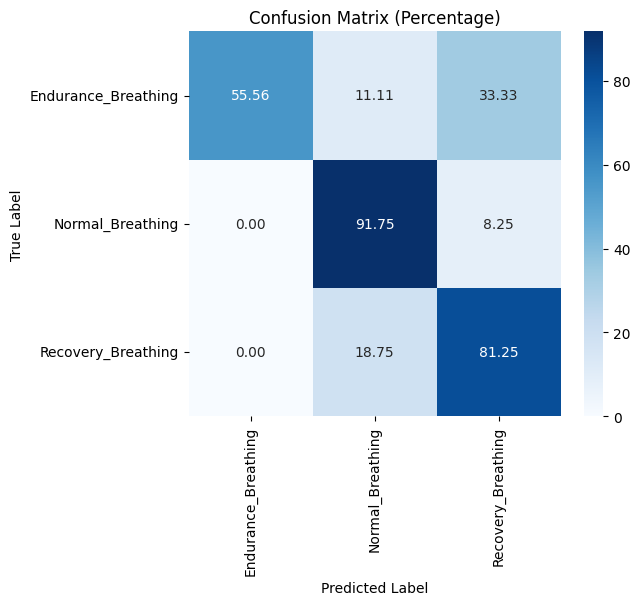

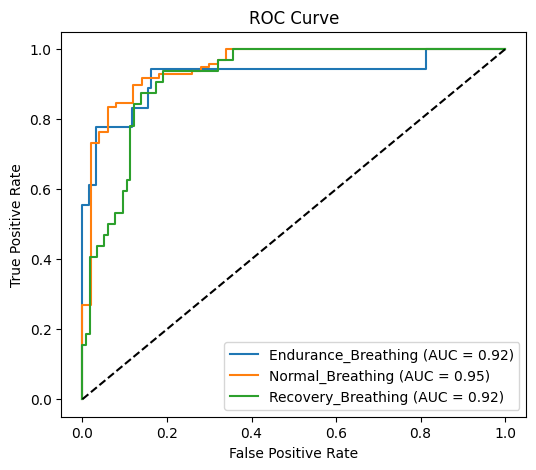


Performance Metrics:
                 Class  Precision  Recall  F1 Score  Support  Accuracy    Loss
0  Endurance Breathing     1.0000  0.5556    0.7143       18    0.8503  0.4657
1     Normal Breathing     0.9175  0.9175    0.9175       97    0.8503  0.4657
2   Recovery Breathing     0.6500  0.8125    0.7222       32    0.8503  0.4657
3              Overall     0.8558  0.7619    0.7847      147    0.8503  0.4657


In [6]:

#LSTM MODEL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_Cleaned_QIR.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Evaluate model
loss = model.evaluate(X_test, y_test, verbose=0)[0]
accuracy = accuracy_score(y_test_labels, y_pred)

# Compute classification metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
class_names = ['Endurance Breathing', 'Normal Breathing', 'Recovery Breathing']

# Build performance table
performance_table = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Support": support
})

# Add overall metrics
overall_row = pd.DataFrame([{
    "Class": "Overall",
    "Precision": precision.mean(),
    "Recall": recall.mean(),
    "F1 Score": f1.mean(),
    "Support": support.sum()
}])
performance_table = pd.concat([performance_table, overall_row], ignore_index=True)

# Add loss and accuracy as new columns (same for all rows)
performance_table["Accuracy"] = accuracy
performance_table["Loss"] = loss

# Display the table
print("\nPerformance Metrics:")
print(performance_table.round(4))

# Save as CSV
performance_table.to_csv("/mnt/data/performance_table.csv", index=False)


Dataset Shape: (109971, 7)
First Few Rows:
    Sensor1_Temp  Sensor1_Pressure  Sensor1_Humidity  Sensor2_Temp  \
0          0.06            0.0263              0.01          0.05   
1          0.05            0.0261              0.01          0.04   
2          0.04            0.0221              0.19          0.03   
3          0.04            0.0119              0.32          0.03   
4          0.04            0.0117              0.38          0.03   

   Sensor2_Pressure  Sensor2_Humidity Label  
0            0.0338               0.0     N  
1            0.0440               0.0     N  
2            0.0562               0.0     N  
3            0.0457               0.0     N  
4            0.0344               0.0     N  
After Dropping NaN - Shape: (109971, 7)
Epoch 1/50
19/19 [==============================] - 10s 202ms/step - loss: 1.0280 - accuracy: 0.6007 - val_loss: 0.9640 - val_accuracy: 0.6871
Epoch 2/50
19/19 [==============================] - 3s 152ms/step - loss: 0.9328 -

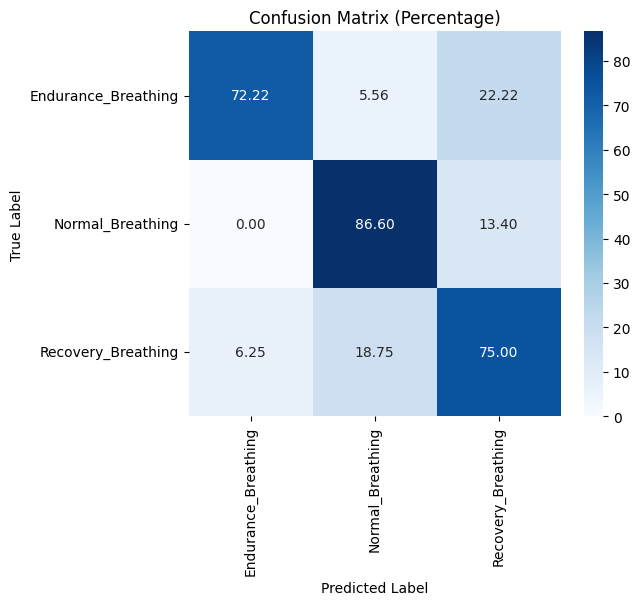

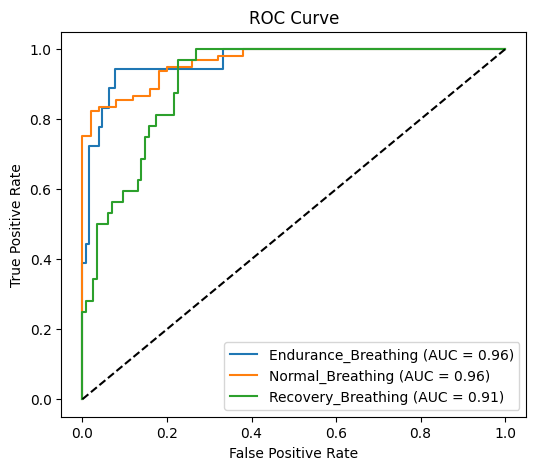


Performance Metrics:
                 Class  Precision  Recall  F1 Score  Support  Accuracy    Loss
0  Endurance Breathing     0.8667  0.7222    0.7879       18    0.8231  0.4051
1     Normal Breathing     0.9231  0.8660    0.8936       97    0.8231  0.4051
2   Recovery Breathing     0.5854  0.7500    0.6575       32    0.8231  0.4051
3              Overall     0.7917  0.7794    0.7797      147    0.8231  0.4051
Model training completed and saved.


In [5]:
#GRU
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support
import joblib

# Load dataset
file_path = "C:\\Users\\ADWIN ADI\\Downloads\\breathing.csv files\\MainData_Cleaned_QIR.csv"
df = pd.read_csv(file_path)

# Print dataset info
print("Dataset Shape:", df.shape)
print("First Few Rows:\n", df.head())

# Drop NaN values
df.dropna(inplace=True)
print("After Dropping NaN - Shape:", df.shape)

# Ensure dataset is not empty after dropping NaN values
if df.empty:
    raise ValueError("Dataset is empty after dropping NaN values. Check the CSV file!")

# Select features (all columns except the last one) and target (last column)
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
joblib.dump(label_encoder, "/mnt/data/label_encoder.pkl")

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.nan_to_num(X_scaled)
joblib.dump(scaler, "/mnt/data/scaler.pkl")

# Verify no NaN values exist
if np.isnan(X_scaled).any() or np.isnan(y_encoded).any():
    raise ValueError("NaN values detected in dataset after preprocessing!")

# Segment data into 10-second windows at 15 Hz (150 samples per segment)
segment_size = 150
num_segments = len(X_scaled) // segment_size
if num_segments == 0:
    raise ValueError(f"Not enough samples for segmentation! Required: {segment_size}, Found: {len(X_scaled)}")

X_segmented = np.array([X_scaled[i * segment_size:(i + 1) * segment_size] for i in range(num_segments)])

def majority_label(labels):
    return np.bincount(labels).argmax()

y_segmented = np.array([majority_label(y_encoded[i * segment_size:(i + 1) * segment_size]) for i in range(num_segments)])

# One-hot encode labels
ohe = OneHotEncoder(sparse_output=False)
y_segmented_ohe = ohe.fit_transform(y_segmented.reshape(-1, 1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_segmented, y_segmented_ohe, test_size=0.2, random_state=42)

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Save trained model
model.save("/mnt/data/breathing_pattern_model.h5")

# Predict test labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Confusion matrix (percentage format)
cm = confusion_matrix(y_test_labels, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'], 
            yticklabels=['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
class_labels = ['Endurance_Breathing', 'Normal_Breathing', 'Recovery_Breathing']

for i in range(y_train.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Evaluate model
loss = model.evaluate(X_test, y_test, verbose=0)[0]
accuracy = accuracy_score(y_test_labels, y_pred)

# Compute classification metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test_labels, y_pred, labels=[0, 1, 2])
class_names = ['Endurance Breathing', 'Normal Breathing', 'Recovery Breathing']

# Build performance table
performance_table = pd.DataFrame({
    "Class": class_names,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Support": support
})

# Add overall metrics
overall_row = pd.DataFrame([{
    "Class": "Overall",
    "Precision": precision.mean(),
    "Recall": recall.mean(),
    "F1 Score": f1.mean(),
    "Support": support.sum()
}])
performance_table = pd.concat([performance_table, overall_row], ignore_index=True)

# Add loss and accuracy as new columns (same for all rows)
performance_table["Accuracy"] = accuracy
performance_table["Loss"] = loss

# Display the table
print("\nPerformance Metrics:")
print(performance_table.round(4))

# Save as CSV
performance_table.to_csv("/mnt/data/performance_table.csv", index=False)

print("Model training completed and saved.")
